## 3. Meta-Learning Layer

> This is the brain that decides *what’s worth learning*.

### Components:

* Meta-feature extractor: entropy, volatility, predictability, residuals, etc.
* Transferability classifier: “Will an agent trained here generalize?”
* Predictability classifier: “Will an agent trained here learn *anything*?”
* Trust classifier: “Will the prediction of the base model be correct?”

### Landmarks:
* Transferability classifier
* Trust classifier

### Next Steps:
* Curriculum similarity & residual forecasting (under development)


This filters **which episodes are learnable, reusable, and worth spending resources on.**


In [1]:
import jupyter

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym

from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import skew, kurtosis, entropy
from statsmodels.stats.diagnostic import acorr_ljungbox

from src.utils.system import boot
from src.defaults import RANDOM_SEEDS, TOP2_STOCK_BY_SECTOR
from tracker import OHLCV_DF, EpisodeTracker, EnvironmentTracker, AgentTracker



In [3]:
ep_tracker = EpisodeTracker()
env_tracker= EnvironmentTracker()
agent_tracker=AgentTracker()

In [12]:
ep= ep_tracker.load_instance(1907)
ticker = ep['ticker'] #"UNH"
target_date=ep['target_date'] #2024-08-01"
target_date

'2024-08-01'

In [13]:
episodes = ep_tracker.findEpisode(
                        target_date,
                        ticker,
                        episode_length=50,
                        lookback=0,
                        mode="both",
                    )
train_episode = episodes["train"]
test_episode = episodes["test"]

train_episode['df'].iloc[0][['symbol','date']],test_episode['df'].iloc[0][['symbol','date']],target_date

(symbol                    UNH
 date      2022-01-04 00:00:00
 Name: 0, dtype: object,
 symbol                    UNH
 date      2022-01-04 00:00:00
 Name: 0, dtype: object,
 '2024-08-01')

In [14]:
train_env_config = {
    "ticker":ticker,
    "n_timesteps": 50,
    "lookback": 0,
    "market_features": ["close", "price_change", "volume_change"],
    "seed": 314,
    "start_idx": train_episode["df_start_iloc"],  # type: ignore
}
test_env_config = {
    "ticker":ticker,
    "n_timesteps": 50,
    "lookback": 0,
    "market_features": ["close", "price_change", "volume_change"],
    "seed": 314,
    "start_idx": test_episode["df_start_iloc"],  # type: ignore
}

In [25]:
episodes = ep_tracker.findEpisode(
                        "2024-08-01",
                        "UNH",
                        episode_length=50,
                        lookback=0,
                        mode="both",
                    )
train_episode = episodes["train"]
test_episode = episodes["test"]
env_tracker = EnvironmentTracker()
train_env_config = {
                        "ticker": "UNH",
                        "n_timesteps": 50,
                        "lookback": 0,
                        "market_features": ["close", "price_change", "volume_change"],
                        "seed": 314,
                        "start_idx": train_episode["df_start_iloc"],  # type: ignore
                    }
test_env_config = train_env_config.copy()
test_env_config["start_idx"] = test_episode["df_start_iloc"] # type: ignore

env_info = env_tracker.findEnvironment(
        version="v2", config=train_env_config
)
train_env = env_info["environment"]
test_env = env_tracker.findEnvironment(
                        version="v2", config=test_env_config
                    )

test_env = test_env["environment"]
test_env.reset()

#test_env.ticker = "UNH"
#print(test_env_config,test_env.episode_df)
tracker = AgentTracker()
                    
agent_config= {
        "model_class": "PPO",
        "policy_class": "MlpPolicy",
        "config": {
            "verbose": 1,
            "ent_coef":0.1,
            "policy_kwargs": 
                {
                
                    "net_arch": [64, 64]
                    }
                }
    }
agent = tracker.findAgent(
                        **agent_config
                   
                    )
_model = agent["model"].boot(train_env)
_model.learn(total_timesteps=50_000)


In [26]:
obs = train_env.reset()[0]
done = False


while not done:
    action, _ = _model.predict(obs, deterministic=True)
    obs, reward, done, _, info = train_env.step(action)
  

obs = test_env.reset()[0]
done = False

while not done:
    action, _ = _model.predict(obs, deterministic=True)
    obs, reward, done, _, info = test_env.step(action)
  

In [23]:
train_env.total_reward,test_env.total_reward
#v4 (3.9094726166979856, 0.9253340867671227)

(3.9094726166979856, 0.9253340867671227)

In [27]:
train_env.total_reward,test_env.total_reward
#V2 (2.943213422121966, 0.35555522285995345)

(2.943213422121966, 0.35555522285995345)

<Axes: >

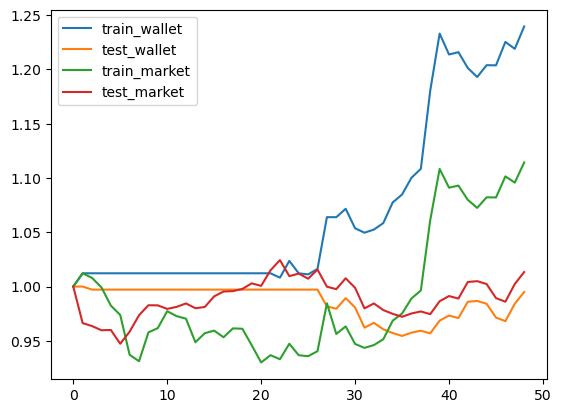

In [28]:
pd.DataFrame({"train_wallet":train_env.wallet_progress,"test_wallet":test_env.wallet_progress,"train_market":train_env.market_progress,"test_market":test_env.market_progress}).plot()

In [ ]:
# V4

<Axes: >

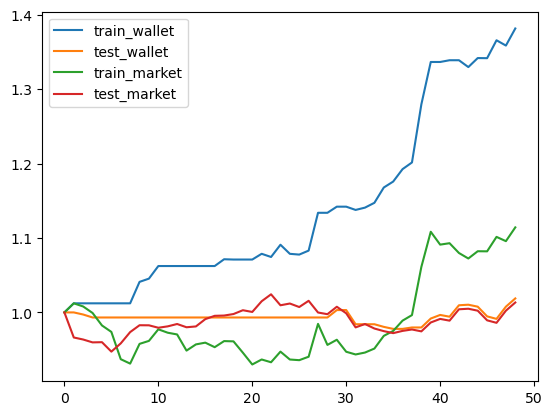

In [24]:
pd.DataFrame({"train_wallet":train_env.wallet_progress,"test_wallet":test_env.wallet_progress,"train_market":train_env.market_progress,"test_market":test_env.market_progress}).plot()